Fitting loop removal from predicition loop
to increase script interpretibility.

Plot in green segment of resampling curve used for fitting
Plot in red prediction segment

In [2]:
# Import packeages, read files, set bounds and inverse power function

import pandas as pd
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from scipy.optimize import curve_fit
import numpy as np # need for linspace in plot
from statistics import mean
import statistics
import time
import math
import json
from sklearn.linear_model import LinearRegression
import matplotlib.patches as mpatches
pd.options.display.max_rows = 500

colors = pd.read_csv('TMP_cohort_colors_n26_20210228.csv',
                     sep = ',', skiprows = 1, names = ['Cohort', 'Hexi'])

sample_response_DF = pd.read_csv('sample_response_DF_20210805.tsv',
                                          sep = '\t')

lower = [0,-1000,-1]
upper = [.5,1000,0]

def Y_acc(x, a, b, c): # x is sample size
    Y_acc = (1-a)-b*x**c
    return Y_acc

In [5]:
sample_response_DF.head(4) # Devel on BRCA and BLCA (full response, can compare prediction to actual)
# True prediction on ACC

,Cohort,Sample_size_100_accuracies
0,ACC,"{""5"": [0.34285714285714286, 0.6901098901098901..."
1,BLCA,"{""5"": [0.0, 0.8, 0.901010101010101, 0.35606060..."
2,BRCA,"{""5"": [0.4499999999999999, 0.8967032967032967,..."
3,CESC,"{""5"": [0.6329966329966329, 1.0, 0.52, 0.355555..."


In [ ]:
skcm over fit

In [ ]:
prad good, lgggbm

In [6]:
cohort_index = 3 # Toggle cohorts

# Set cohort and load primary accuracy response object
cohort = sample_response_DF.iloc[cohort_index,0]
print(cohort)

accuracy_response_dict = {
    int(k):[i for i in v] for k,v in json.loads(
        sample_response_DF.iloc[cohort_index,1]).items()}

CESC


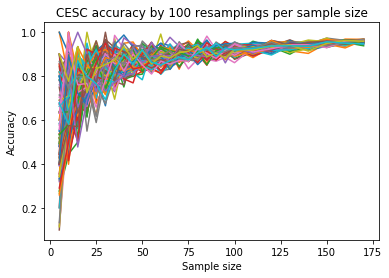

In [7]:
# Create list of tuples
accuracy_response = sorted(accuracy_response_dict.items())

# Inspect the 100 raw scores per sample size
x, y = zip(*accuracy_response) # unpack a list of pairs into two tuples
plt.plot(x, y)
plt.title(cohort+' accuracy by 100 resamplings per sample size')
plt.xlabel('Sample size')
plt.ylabel('Accuracy')
plt.savefig(cohort + '_raw_data.png')
plt.show()

Sample size fitting threshold on front of curve: 45


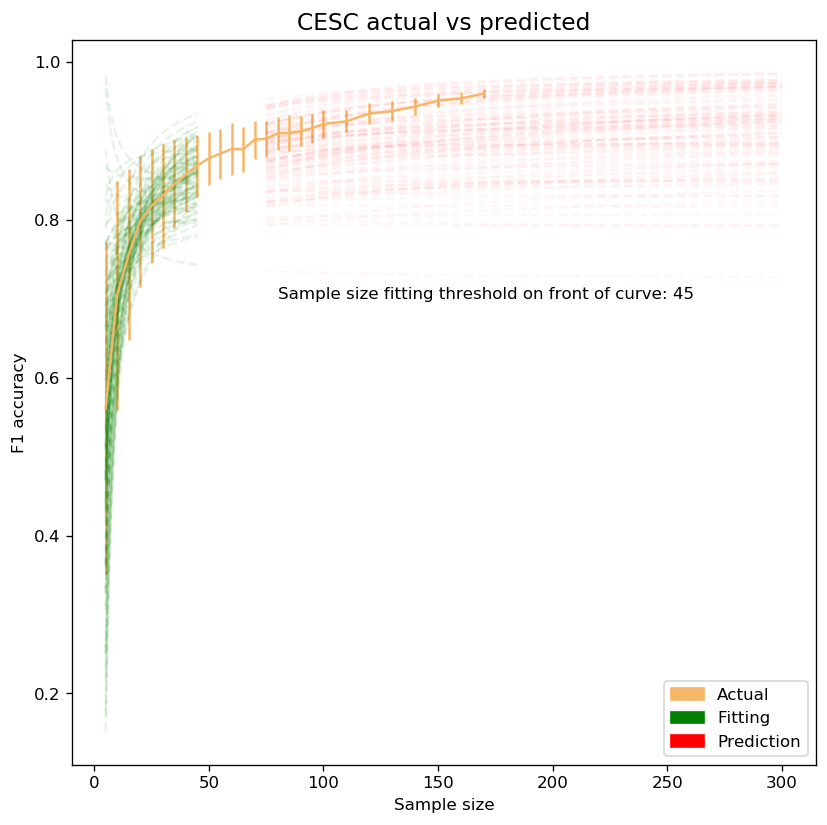

In [8]:
# Un-nest fitting loop from prediction loop

prediction_sample_sizes = [75,100,125,150,175,200,225,250,275,300] # template for automation of max sample size for fitting
prediction_curve_x = np.linspace(75, 300, 100)
sample_sizes = list(i[0] for i in accuracy_response)

predictions = []
conf_95 = []
conf_90 = []
CI_upper = []
CI_lower = []
stdev = []
stdev_upper = []
stdev_lower = []

sampling_threshold = 8 # Toggle threshold by index of index of upper limit sample size
front_end_fitting_cutoff = sample_sizes[sampling_threshold]
print('Sample size fitting threshold on front of curve: ' + str(front_end_fitting_cutoff))

actual_scores = []
for i in accuracy_response:
    actual_scores.append(mean(i[1]))
      
stdevs = []
for i in accuracy_response:
    stdevs.append(statistics.stdev(i[1]))

# Setup plot
fig, ax = plt.subplots(figsize = (8,8), dpi = 120)
color_shard = colors[colors.Cohort == cohort]
colr = color_shard.iloc[0,1]

# Plot actual with standard deviation
ax.errorbar(sample_sizes,
            actual_scores,
            yerr = stdevs, color = colr, alpha = .99)
      
# Curve fitting to front end of curves
front_end_parameters = {}
y_predictions = []
for resampling_idx in list(range(0,100)):

    scores_temp = [] # 100 scores for each sample size on restricted front-end portion of curve

    for tuple_n in accuracy_response:
        scores_temp.append(tuple_n[1][resampling_idx])
#     print('scores temp: ' + str(scores_temp))

    front_end_param_set_n, _ = curve_fit(Y_acc,
                             sample_sizes[0:sampling_threshold],
                             scores_temp[0:sampling_threshold],
                                bounds=[lower,upper])
    front_end_parameters[resampling_idx] = front_end_param_set_n
    
    # Now, plot all 100 front-end fitting curves and compare to actual 
    x_fit = np.linspace(sample_sizes[0], front_end_fitting_cutoff, 50)
    y_fit = Y_acc(x_fit, *front_end_param_set_n)
    ax.plot(x_fit, y_fit, '--', color = 'green', alpha = .09)
      
    y_predict = Y_acc(prediction_curve_x, *front_end_param_set_n)
    ax.plot(prediction_curve_x, y_predict, '--', color = 'red', alpha = .03)
    y_predictions.append(y_predict)
# average_prediction
          
ax.set_xlabel('Sample size')
ax.set_ylabel('F1 accuracy')
plt.title(cohort +
    ' actual vs predicted',
    fontsize = 14)
patch_1 = mpatches.Patch(color=colr, label='Actual')
patch_2 = mpatches.Patch(color='green', label='Fitting')
patch_3 = mpatches.Patch(color='red', label='Prediction')
plt.legend(handles=[patch_1, patch_2, patch_3])
plt.text(80, .7, 'Sample size fitting threshold on front of curve: ' + str(front_end_fitting_cutoff))
plt.savefig(cohort + '_'+str(front_end_fitting_cutoff)+ '_predict_v3.png')
plt.show()

In [104]:
# Code parking lot
# Save front-end of curve parameters to make 100 predictions at sample sizes beyond the fitting range
front_endDF = pd.DataFrame(front_end_parameters).transpose()
front_endDF.columns = ['a','b','c']